In [1]:
#starting imports we will need 
#Pandas is python's data analysis library, which makes it 
#much easier to work with the data.

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
#Reading in the data from the csv files provided on Kaggle.
#skipping 2001 - 2004 due to bad quality, panda doesn't load them nicely

crimes1 = pd.read_csv('../input/Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False)
crimes2 = pd.read_csv('../input/Chicago_Crimes_2008_to_2011.csv',error_bad_lines=False)
train = pd.concat([crimes1, crimes2], ignore_index=False, axis=0)
test = pd.read_csv('../input/Chicago_Crimes_2012_to_2017.csv',error_bad_lines=False)

del crimes1
del crimes2

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [3]:
#Next we need to clean up the data

train.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
test.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)

#we want to ensure that test has no data entries
#that are found in train. found how to do this here:
#https://stackoverflow.com/questions/37313691/how-to-remove-a-pandas-dataframe-from-another-dataframe
pd.concat([test, train, train]).drop_duplicates(keep=False)

train.drop(['Unnamed: 0', 'Case Number', 'Updated On', 'FBI Code', 'Ward','Community Area', 'Latitude', 'Longitude', 'Location'], inplace=True, axis=1)
test.drop(['Unnamed: 0', 'Case Number', 'Updated On', 'FBI Code', 'Ward','Community Area', 'Latitude', 'Longitude', 'Location'], inplace=True, axis=1)

# convert dates to pandas datetime format
train.Date = pd.to_datetime(train.Date, format='%m/%d/%Y %I:%M:%S %p')
test.Date = pd.to_datetime(test.Date, format='%m/%d/%Y %I:%M:%S %p')

# setting the index to be the date will help later on
train.index = pd.DatetimeIndex(train.Date)
test.index = pd.DatetimeIndex(test.Date)

#next, make the data less noisy by only keeping the top 20 location descriptions and crime descriptions
loc_to_change  = list(train['Location Description'].value_counts()[20:].index)
desc_to_change = list(train['Description'].value_counts()[20:].index)

train.loc[train['Location Description'].isin(loc_to_change) , train.columns=='Location Description'] = 'OTHER'
train.loc[train['Description'].isin(desc_to_change) , train.columns=='Description'] = 'OTHER'

# we convert those 3 columns into 'Categorical' types -- works like 'factor' in R
# train['Primary Type']         = pd.Categorical(train['Primary Type'])
# train['Location Description'] = pd.Categorical(train['Location Description'])
# train['Description']          = pd.Categorical(train['Description'])
# train['Block'] = pd.Categorical(train['Block']) 
# train['IUCR'] = pd.Categorical(train['IUCR'])

In [4]:
#do some unsupervised learning and try to cluster the data
#we will print out the results with heat maps

from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

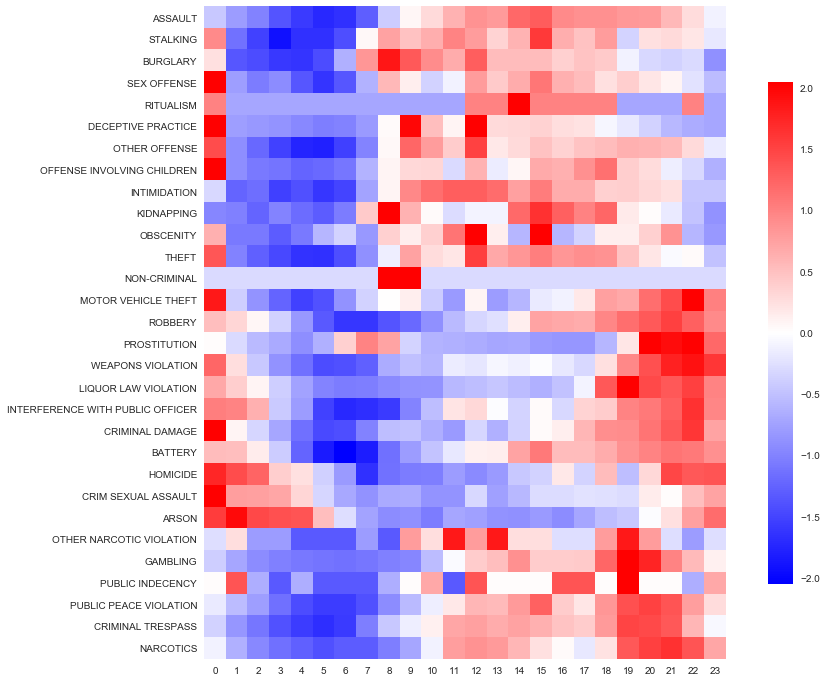

In [5]:
#lets plot the most likely times each crime will occur in a given day.
#red means the crime is most likely to occur at these times, blue means it is least likely to occur, and white means 
#the crime may occur at these times.

hour_by_type = train.pivot_table(values='ID', index='Primary Type', columns=train.index.hour, aggfunc=np.size).fillna(0)
plt.figure(figsize=(15,12))
scale_and_plot(hour_by_type)

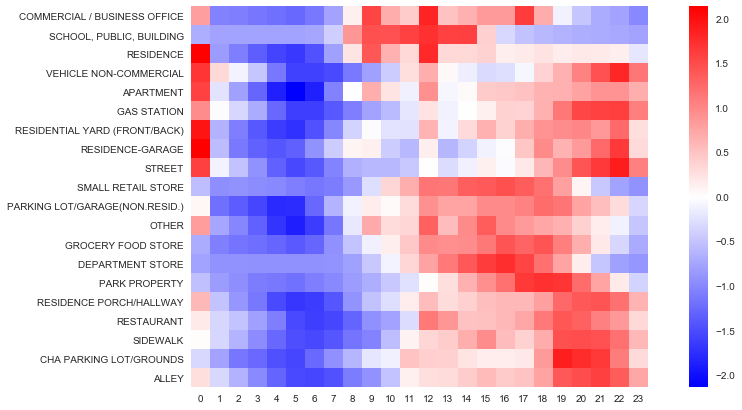

In [6]:
#we can also plot the most likely times that a crime will occur at a given location

hour_by_location = train.pivot_table(values='ID', index='Location Description', columns=train.index.hour, aggfunc=np.size).fillna(0)
plt.figure(figsize=(15,7))
scale_and_plot(hour_by_location)

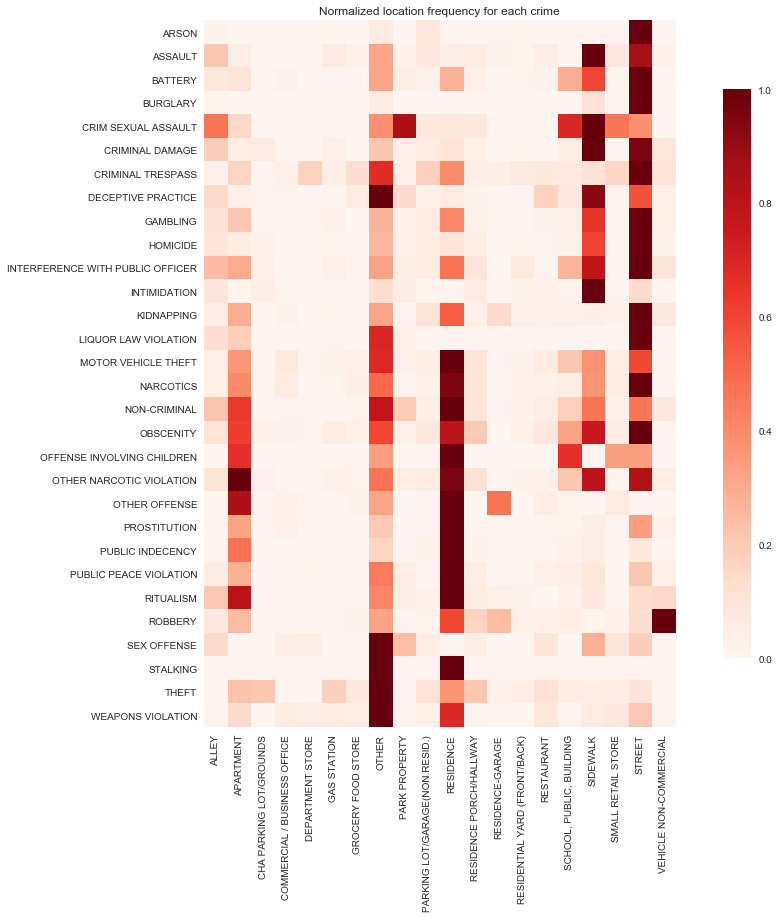

In [7]:
#lastly we plot the most likely location at which certain crimes will occur

location_by_type = train.pivot_table(values='ID', index='Location Description', columns='Primary Type', aggfunc=np.size).fillna(0)
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()

In [8]:
train.head(3)

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,X Coordinate,Y Coordinate,Year
Date,,,,,,,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,1622,16.0,1136872.0,1936499.0,2006
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,2017,NARCOTICS,OTHER,SIDEWALK,True,False,321,3.0,1181027.0,1861693.0,2006
2006-01-08 23:16:00,4673628,2006-01-08 23:16:00,013XX E 69TH ST,051A,ASSAULT,OTHER,OTHER,False,False,321,3.0,1186023.0,1859609.0,2006


In [32]:
#we are going to predict where future crimes will occur, based off a 
#neural network
#the heat map showed us that we should be able to narrow a crime 
#down to top three most likely locations.

#data preprocessing, we want to normalize it
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

train['Location Description'] = lb_make.fit_transform(train['Location Description'].fillna('0'))
x_train = train.drop('Location Description', axis = 1)
y_train = train['Location Description']

x_train['Date'] = lb_make.fit_transform(x_train['Date'])
x_train['Block'] = lb_make.fit_transform(x_train['Block'])
x_train['IUCR'] = lb_make.fit_transform(x_train['IUCR'])
x_train['Primary Type'] = lb_make.fit_transform(x_train['Primary Type'])
x_train['Description'] = lb_make.fit_transform(x_train['Description'])

test['Location Description'] = lb_make.fit_transform(test['Location Description'].fillna('0'))
x_test = test.drop('Location Description', axis = 1)
y_test = test['Location Description']

x_test['Date'] = lb_make.fit_transform(x_test['Date'])
x_test['Block'] = lb_make.fit_transform(x_test['Block'])
x_test['IUCR'] = lb_make.fit_transform(x_test['IUCR'])
x_test['Primary Type'] = lb_make.fit_transform(x_test['Primary Type'])
x_test['Description'] = lb_make.fit_transform(x_test['Description'])

x_train = x_train.fillna(0)
y_train = y_train.fillna(0)
x_test = x_test.fillna(0)
y_test = y_test.fillna(0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#fit only to the training data
scaler.fit(x_train)

StandardScaler(copy = True, with_mean= True, with_std=True)

#now we normalize the data, according to the training tendencies
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

11
Date
2016-05-03 23:40:00     18
2016-05-03 21:40:00    112
2016-05-03 23:31:00    128
Name: Location Description, dtype: int64


In [38]:
#time to train our neural network
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter = 100)
mlp.fit(x_train, y_train)

C:\Users\Shawn\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [37]:
#time to do predictions and evaluation
predictions = mlp.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1658
          1       0.00      0.00      0.00      3703
          2       0.00      0.01      0.01       398
          3       0.00      0.00      0.00       414
          4       0.01      0.10      0.01       302
          5       0.00      0.00      0.00       346
          6       0.00      0.00      0.00       167
          7       0.00      0.00      0.00       380
          8       0.00      0.02      0.00       832
          9       0.00      0.00      0.00       322
         10       0.00      0.00      0.00        40
         11       0.00      0.02      0.00       306
         12       0.00      0.00      0.00      2435
         13       0.00      0.00      0.00        53
         14       0.00      0.00      0.00       651
         15       0.00      0.00      0.00       462
         16       0.01      0.00      0.00     31771
         17       0.00      0.00      0.00   

C:\Users\Shawn\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
